# Import libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
import os
import math
import json
import pickle
import numpy    as np
import pandas   as pd
from   datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn
from sklearn                 import metrics
from sklearn.model_selection import train_test_split
from sklearn                 import preprocessing
from sklearn.metrics         import ConfusionMatrixDisplay
from sklearn.metrics         import PrecisionRecallDisplay
import skopt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# XGBoost
import xgboost

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
from utils.Logger   import *

# Parameters

In [2]:
# HPO parameters 
n_calls         =  10
n_random_starts =  1

# XGBoost - parameters
n_estimators          = 1000
early_stopping_rounds = 50
seed                  = 42

# Other parameters
VERBOSE = True

# Create directory for storing output figures
if ~os.path.isdir('Figures'): os.mkdir('Figures')

In [3]:
# Initiate logger
#
if VERBOSE:
    logger = init_logger( log_file = 'logs.log' ) 

# Loading data

## Training data

In [4]:
df_train = pd.read_csv('Data/train_data.csv')

if VERBOSE:
    logger.info(f'Training data were loaded')
    logger.info(f'Number of instances:  {df_train.shape[0]}')
    logger.info(f'Number of features:   {df_train.shape[1]}')

df_train.head( 3 )

[INFO] Training data were loaded
[INFO] Number of instances:  82503
[INFO] Number of features:   29


,Feature-1,Feature-2,Feature-3,Feature-4,Feature-5,Feature-6,Feature-7,Feature-8,Feature-9,Feature-10,...,Feature-20,Feature-21,Feature-22,Feature-23,Feature-24,Feature-25,Feature-26,Feature-27,Feature-28,label
0,0.325158,0.211388,0.162878,0.199771,0.163840,-0.267323,0.014312,0.324716,0.204250,0.174650,...,-0.264708,0.041466,0.315360,0.201311,0.161962,0.191630,0.159782,-0.262815,0.039018,0
1,0.283810,0.185874,0.204715,0.292734,0.321123,-0.359163,0.263899,0.283403,0.185829,0.195995,...,-0.353670,0.287560,0.262824,0.169689,0.170315,0.270060,0.288574,-0.334296,0.248330,1
2,0.323059,0.200238,0.199566,0.288144,0.347120,-0.392760,0.259642,0.350821,0.223944,0.210791,...,-0.439905,0.268981,0.323004,0.195420,0.183496,0.256162,0.310311,-0.361256,0.211741,1


## Testing data

In [5]:
df_test = pd.read_csv('Data/test_data.csv')

if VERBOSE:
    logger.info(f'Testing data were loaded')
    logger.info(f'Number of instances:  {df_test.shape[0]}')
    logger.info(f'Number of features:   {df_test.shape[1]}')

df_test.head( 3 )

[INFO] Testing data were loaded
[INFO] Number of instances:  9168
[INFO] Number of features:   29


,Feature-1,Feature-2,Feature-3,Feature-4,Feature-5,Feature-6,Feature-7,Feature-8,Feature-9,Feature-10,...,Feature-20,Feature-21,Feature-22,Feature-23,Feature-24,Feature-25,Feature-26,Feature-27,Feature-28,label
0,0.421100,0.311280,0.310160,0.353980,0.105571,-0.175377,0.091689,0.420820,0.306320,0.310420,...,-0.193568,0.095023,0.388280,0.273980,0.285980,0.330560,0.105511,-0.177666,0.116607,0
1,0.423193,0.290619,0.254927,0.281671,0.137560,-0.244459,0.019792,0.431956,0.301435,0.257873,...,-0.239738,0.043115,0.379723,0.252394,0.238974,0.265378,0.135794,-0.245699,0.070134,1
2,0.319944,0.240518,0.192145,0.214765,0.104318,-0.246053,-0.044005,0.343052,0.246591,0.211662,...,-0.236559,0.004437,0.333574,0.236871,0.211484,0.236254,0.110759,-0.240793,0.024197,0


## Training/Testing sets

In [6]:
# Training/Validation data
trainX = df_train.iloc[:, :-1]
trainY = df_train.iloc[:,  -1]
trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size = 0.2, random_state = seed)

# # Convert dataset to special XGBoost optimised data structure
# dtrain = xgboost.DMatrix(trainX, label = trainY)
# dvalid = xgboost.DMatrix(validX, label = validY)


# Testing data
testX  = df_test.iloc[:, :-1]
testY  = df_test.iloc[:,  -1]

# Hyperparameter optimization

In [7]:
# Initiate mlflow server
# Command: mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 127.0.0.1 --port 5000
# 
import mlflow
from   mlflow.models.signature import infer_signature

mlflow.set_tracking_uri("http://127.0.0.1:1983/")
mlflow.set_experiment("NVCR-Experiments")

if VERBOSE:
    logger.info('MLFlow server is connected')

2023/03/23 09:29:38 INFO mlflow.tracking.fluent: Experiment with name 'NVCR-Experiments' does not exist. Creating a new experiment.
[INFO] MLFlow server is connected


In [8]:
class Parameter_Evaluation():
    def __init__(self, trainX, trainY, validX, validY, VERBOSE = True):
        # Data
        self.trainX = trainX
        self.trainY = trainY
        self.validX = validX
        self.validY = validY
        # 
        self.VERBOSE = VERBOSE
        # Number of iterations
        self.Iter = 1
        # Best score
        self.best_score = 0
        
    def select_model(self, model):
        self.model = model
    
    def get_performance_evaluation(self, y, pred):
        Accuracy  = 100.0 * metrics.accuracy_score(y, pred)
        try:
            AUC   = metrics.roc_auc_score(y, pred)
        except:
            AUC   = 0.0
        Recall    = metrics.recall_score(y, pred)
        Precision = metrics.precision_score(y, pred)     

        # Calculate Confusion Matrix (CM)
        CM = metrics.confusion_matrix(y, pred)
        GM = math.sqrt( np.diag( CM ).prod() ) / math.sqrt( CM[0, :].sum() * CM[1, :].sum() )
            
        return Accuracy, AUC, Precision, Recall, GM, CM
    
    def evaluate_params(self, params):
        
        tag     = {"Simulation" : "sample-" + str(self.Iter), "model": "XGBoost"}
        runname = "XGBoost-test-run-" + str(self.Iter)

        with mlflow.start_run(run_name = runname) as run:
            # Tags to help in tracking
            mlflow.set_tags(tag)
            
            # Log params/hyperparameters used in experiement
            mlflow.log_params(params)
            
    
            # Setup model
            #
            model =  self.model.set_params( **params )
            
            # Train model
            #
            model.fit(self.trainX, self.trainY, 
                      eval_metric = 'auc', 
                      eval_set = [ (self.trainX, self.trainY), (self.validX, self.validY) ],
                      early_stopping_rounds = early_stopping_rounds,
                      verbose = 100);

            
            # Evaluation on Training set
            pred = model.predict( self.trainX )        
            Accuracy, AUC, Precision, Recall, GM, CM = self.get_performance_evaluation(self.trainY.values, pred)
            # Log metrics to MLflow
            mlflow.log_metric("train_Accuracy", Accuracy)
            mlflow.log_metric("train_AUC", AUC)
            mlflow.log_metric("train_Recall", Recall)
            mlflow.log_metric("train_Precision", Precision)
            mlflow.log_metric("train_GM", GM)
            
            # Confusion matrix (Training)
            disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
            ax = plt.figure(figsize=(4,4)).gca()
            fig = disp.plot(ax=ax,cmap = 'Blues', colorbar=False);
            plt.title('Confusion Matrix - Train')
            fig.figure_.savefig('Figures/CM_train.png', dpi=100)
            plt.show()
            
            # PR-curve (Training)
            ax = plt.figure(figsize=(4,3)).gca()
            display = PrecisionRecallDisplay.from_estimator(model, self.trainX, self.trainY, ax=ax)
            display.ax_.set_title("2-class Precision-Recall curve");
            display.figure_.savefig('Figures/PR-curve_train.png', dpi=100)
            plt.show()
            
            
            # Evaluation on Validation set
            pred = model.predict( self.validX )        
            Accuracy, AUC, Precision, Recall, GM, CM = self.get_performance_evaluation(self.validY.values, pred)
            # Log metrics to MLflow
            mlflow.log_metric("valid_Accuracy", Accuracy)
            mlflow.log_metric("valid_AUC", AUC)
            mlflow.log_metric("valid_Recall", Recall)
            mlflow.log_metric("valid_Precision", Precision)
            mlflow.log_metric("valid_GM", GM)
            
            # Confusion matrix (Testing)
            disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
            ax = plt.figure(figsize=(4, 4)).gca()
            fig = disp.plot(ax=ax,cmap = 'Blues', colorbar=False);
            plt.title('Confusion Matrix - Test')
            fig.figure_.savefig('Figures/CM_test.png', dpi=100)
            plt.show()
            
            # PR-curve (Testing)
            ax = plt.figure(figsize=(4,3)).gca()
            display = PrecisionRecallDisplay.from_estimator(model, self.validX, self.validY, ax=ax)
            display.ax_.set_title("2-class Precision-Recall curve");
            display.figure_.savefig('Figures/PR-curve_test.png', dpi=100)
            plt.show()
            
            
            
            # Export results
            if (AUC > self.best_score): self.best_score = AUC
            if self.VERBOSE:
                logger.info( "Iteration {:3.0f} with Accuracy = {:6.3f}% AUC = {:6.3f} GM = {:6.3f}".format(self.Iter, Accuracy, AUC, GM) )
            
            
            # Include model signature
            signature = infer_signature(self.validX, pred)
            
            # Log model created
            mlflow.sklearn.log_model(model, artifact_path = "models", signature = signature) 

            mlflow.log_artifacts("Data", artifact_path="Data")
            mlflow.log_artifacts("Figures", artifact_path="Figures")
            
        mlflow.end_run()
          
        # Update Iteration counter
        self.Iter += 1
        
        
        return( -AUC )

In [ ]:
            mlflow.log_artifacts("Figures", artifact_path="Figures")


In [9]:
evaluator = Parameter_Evaluation(trainX, trainY, validX, validY)

# Prediction model

In [10]:
# Setup model
#
model = xgboost.XGBClassifier(n_estimators        = n_estimators, 
                              n_jobs              = -1, 
                              objective           = 'binary:logistic', 
                              validate_parameters = True, 
                              verbosity           = 1,
                              tree_method         = 'hist',
                              gamma               = 1.5,
                              reg_alpha           = 20,
                              reg_lambda          = 0.7) 

if VERBOSE:
    logger.info('Model was setup')
model

[INFO] Model was setup


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Parameters

In [11]:
# XGBoost
search_space = [ 
                 skopt.space.Categorical([0.1, 0.05, 0.01, 0.05], name='learning_rate'),
                 skopt.space.Integer(3, 15,   name='max_depth'),
                 #
                 skopt.space.Integer(2, 10,   name='min_child_weight'),
                 skopt.space.Integer(2, 5,    name='max_leaves'),
                ]

In [12]:
HPO_params = {
              'n_calls':         n_calls,
              'n_random_starts': n_random_starts,
              'base_estimator':  'ET',
              'acq_func':        'EI',
             }

## Hyperparameter optimization process

In [13]:
evaluator.select_model( model )

In [14]:
@skopt.utils.use_named_args( search_space )
def objective( **params ):
    return  evaluator.evaluate_params( params )

[0]	validation_0-auc:0.65021	validation_1-auc:0.64839
[100]	validation_0-auc:0.75451	validation_1-auc:0.75396
[200]	validation_0-auc:0.77372	validation_1-auc:0.77189
[300]	validation_0-auc:0.78820	validation_1-auc:0.78504
[400]	validation_0-auc:0.79862	validation_1-auc:0.79406
[500]	validation_0-auc:0.80793	validation_1-auc:0.80213
[600]	validation_0-auc:0.81440	validation_1-auc:0.80750
[700]	validation_0-auc:0.82047	validation_1-auc:0.81286
[800]	validation_0-auc:0.82536	validation_1-auc:0.81700
[900]	validation_0-auc:0.82963	validation_1-auc:0.82066
[999]	validation_0-auc:0.83346	validation_1-auc:0.82373


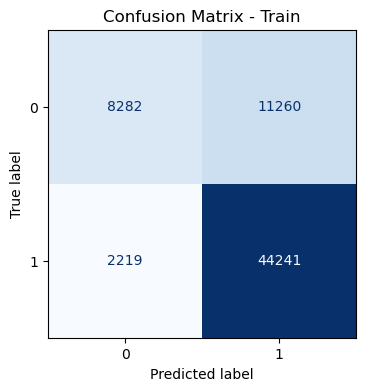

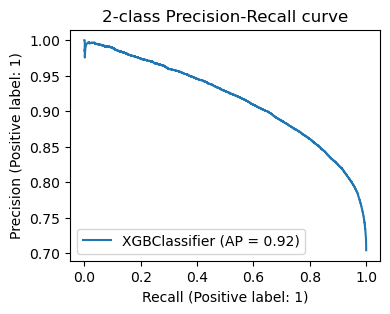

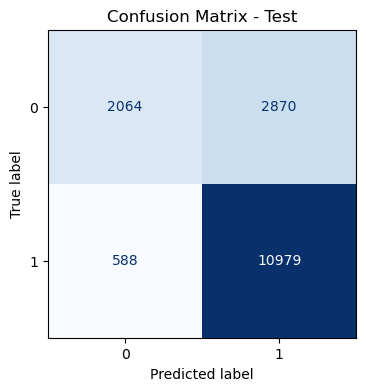

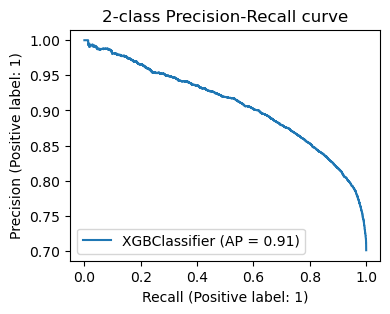

[INFO] Iteration   1 with Accuracy = 79.044% AUC =  0.684 GM =  0.630
2023/03/23 09:30:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\poseidon\AppData\Local\Temp\tmpf94t7gay\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


InvalidParameterError: The 'criterion' parameter of ExtraTreesRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'friedman_mse'}. Got 'mse' instead.

In [15]:
%%time
results = skopt.forest_minimize(objective, search_space, **HPO_params)

## Get optimized hyperparameters

In [ ]:
def to_named_params(results, search_space):
    params       = results.x
    param_dict   = {}
    
    params_list  =[(dimension.name, param) for dimension, param in zip(search_space, params)]
    
    for item in params_list:
        param_dict[item[0]] = item[1]
    
    return( param_dict )

In [ ]:
best_params = to_named_params(results, search_space)


print('[INFO] Optimized hyperparameters\n')
for (parameter,value) in best_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))




# Store optimized hyperparameters
#
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

with open('checkpoint/Hyperparameters.json', 'w', encoding='utf-8') as f:
    f.write( json.dumps( best_params, default = np_encoder ) )
